## Download dataset

In [ ]:
!wget --no-check-certificate https://storage.googleapis.com/emcassavadata/cassavaleafdata.zip -O /content/cassavaleafdata.zip
!unzip /content/cassavaleafdata.zip

Streaming output truncated to the last 5000 lines.
  inflating: cassavaleafdata/train/cgm/train-cgm-679.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-68.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-680.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-681.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-682.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-683.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-684.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-685.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-686.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-687.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-688.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-689.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-69.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-690.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-691.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-692.jpg  
  infla

In [ ]:
import os
import random
import time
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from torchsummary import summary

from PIL import Image
import matplotlib.pyplot as plt

## 2. Pre-processing dataset

In [ ]:
PATH = {
    'train': './cassavaleafdata/train',
    'valid': './cassavaleafdata/validation',
    'test': './cassavaleafdata/test'
}

# Load image from path
def loader(path):
  return Image.open(path)

img_size = 150

train_transforms = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor()
])

train_data = datasets.ImageFolder(
    root=PATH['train'],
    transform=train_transforms,
    loader=loader
)

valid_data = datasets.ImageFolder(
    root=PATH['valid'],
    transform=train_transforms
)

test_data = datasets.ImageFolder(
    root=PATH['test'],
    transform=train_transforms
)

BATCH_SIZE = 256

train_dataloader = data.DataLoader(
    train_data,
    shuffle=True,
    batch_size=BATCH_SIZE
)

valid_dataloader = data.DataLoader(
    valid_data,
    batch_size=BATCH_SIZE
)

## 3. Build model

In [ ]:
class LeNetClassifier(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    self.conv1 = nn.Conv2d(
        in_channels=3, out_channels=6, kernel_size=5, padding='same'
    )
    self.avgpool1 = nn.AvgPool2d(kernel_size=2)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
    self.avgpool2 = nn.AvgPool2d(kernel_size=2)
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(16*35*35, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, num_classes)

  def forward(self, inputs):
    outputs = self.conv1(inputs)
    outputs = self.avgpool1(outputs)
    outputs = F.relu(outputs)
    outputs = self.conv2(outputs)
    outputs = self.avgpool2(outputs)
    outputs = F.relu(outputs)
    outputs = self.flatten(outputs)
    outputs = self.fc1(outputs)
    outputs = self.fc2(outputs)
    outputs = self.fc3(outputs)
    return outputs

## 4. Train model

In [ ]:
# Training function
def train(model, optimizer, criterion, train_dataloader, device, epoch=0, log_interval=50):
  model.train()
  total_acc, total_count = 0, 0
  losses = []
  start_time = time.time()

  for idx, (inputs, labels) in enumerate(train_dataloader):
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()
    predictions = model(inputs)

    # Compute loss
    loss = criterion(predictions, labels)
    losses.append(loss.item())

    # Backward
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
    optimizer.step()
    total_acc += (predictions.argmax(1) == labels).sum().item()
    total_count += labels.size(0)
    if idx % log_interval == 0 and idx > 0:
      elapsed = time.time() - start_time
      print(
          '| epoch {:3d} | {:5d}/{:5d} batches '
          '| accuracy {:8.3f}'.format(
              epoch, idx, len(train_dataloader), total_acc / total_count
          )
      )
      total_acc, total_count = 0, 0
      start_time = time.time()

  epoch_acc = total_acc / total_count
  epoch_loss = sum(losses) / len(losses)
  return epoch_acc, epoch_loss

In [ ]:
# Evaluate function
def evaluate(model, criterion, valid_dataloader):
  model.eval()
  total_acc, total_count = 0, 0
  losses = []

  with torch.no_grad():
    for idx, (inputs, labels) in enumerate(valid_dataloader):
      inputs, labels = inputs.to(device), labels.to(device)
      predictions = model(inputs)

      loss = criterion(predictions, labels)
      losses.append(loss.item())

      total_acc += (predictions.argmax(1) == labels).sum().item()
      total_count += labels.size(0)

  epoch_acc = total_acc / total_count
  epoch_loss = sum(losses) / len(losses)
  return epoch_acc, epoch_loss

In [ ]:
num_classes = len(train_data.classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lenet_model = LeNetClassifier(num_classes)
lenet_model.to(device)

criterion = nn.CrossEntropyLoss()
learning_rate = 2e-4
optimizer = optim.Adam(lenet_model.parameters(), lr=learning_rate)

num_epochs = 10
save_model = './model'

train_accs, train_losses = [], []
eval_accs, eval_losses = [], []
best_loss_eval = 100

for epoch in range(1, num_epochs + 1):
  epoch_start_time = time.time()
  # Training
  train_acc, train_loss = train(
      lenet_model,
      optimizer,
      criterion,
      train_dataloader,
      device,
      epoch,
      log_interval=10
  )
  train_accs.append(train_acc)
  train_losses.append(train_loss)

  # Evaluate
  eval_acc, eval_loss = evaluate(
      lenet_model,
      criterion,
      valid_dataloader,
  )
  eval_accs.append(eval_acc)
  eval_losses.append(eval_loss)

  # Save model
  os.makedirs(save_model, exist_ok=True)
  if eval_loss < best_loss_eval:
    torch.save(lenet_model.state_dict(), save_model + '/lenet_model.pth')

  # Print loss, acc and epoch
  print('-' * 59)
  print(
      '| End of epoch: {:3d} | Time: {:5.2f}s | Train Accuracy {:8.3f} | Train Loss {:8.3f}'
      ' | Valid Accuracy {:8.3f} | Valid Loss {:8.3f}'.format(
          epoch,
          time.time() - epoch_start_time,
          train_acc,
          train_loss,
          eval_acc,
          eval_loss
      )
  )
  print('-' * 59)

  # Load best model
  lenet_model.load_state_dict(torch.load(save_model + '/lenet_model.pth'))
  lenet_model.eval()

| epoch   1 |    10/   23 batches | accuracy    0.426
| epoch   1 |    20/   23 batches | accuracy    0.474
-----------------------------------------------------------
| End of epoch:   1 | Time: 46.52s | Train Accuracy    0.454 | Train Loss    1.365 | Valid Accuracy    0.470 | Valid Loss    1.430
-----------------------------------------------------------


<ipython-input-7-63640ac46411>:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lenet_model.load_state_dict(torch.load(save_model + '/lenet_model.pth'))


| epoch   2 |    10/   23 batches | accuracy    0.464
| epoch   2 |    20/   23 batches | accuracy    0.481
-----------------------------------------------------------
| End of epoch:   2 | Time: 46.06s | Train Accuracy    0.489 | Train Loss    1.310 | Valid Accuracy    0.473 | Valid Loss    1.418
-----------------------------------------------------------
| epoch   3 |    10/   23 batches | accuracy    0.476
| epoch   3 |    20/   23 batches | accuracy    0.523
-----------------------------------------------------------
| End of epoch:   3 | Time: 45.85s | Train Accuracy    0.518 | Train Loss    1.277 | Valid Accuracy    0.525 | Valid Loss    1.391
-----------------------------------------------------------
| epoch   4 |    10/   23 batches | accuracy    0.529
| epoch   4 |    20/   23 batches | accuracy    0.521
-----------------------------------------------------------
| End of epoch:   4 | Time: 44.66s | Train Accuracy    0.521 | Train Loss    1.253 | Valid Accuracy    0.521 | Val

## Evaluate model

In [ ]:
test_dataloader = data.DataLoader(
    test_data,
    batch_size=BATCH_SIZE
)

test_acc, test_loss = evaluate(lenet_model, criterion, test_dataloader)
test_acc, test_loss

(0.5755968169761273, 1.259093388915062)

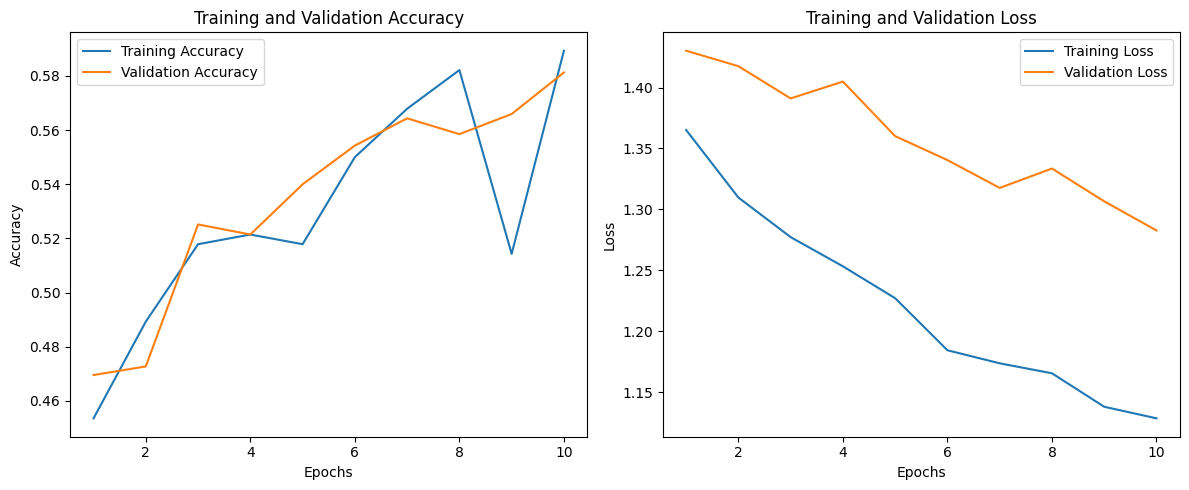

In [ ]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_accs, label='Training Accuracy')
plt.plot(epochs, eval_accs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, eval_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()